In [364]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import os
from typing import List
from pathlib import Path

np.random.seed(444)

# Reading Pyo Output File
The raw output from Pyomo is stored in a text file, so we transform it into a dataframe

In [88]:
#
# This block reads text from the file into lists, converting lines seperated with
# a '|' into entries of lists
#
# eg: 'TotalAcerage    | 24324.0' => ['TotalAcerage', 24324.0]
#

raw_file = Path('../../MiniModelRunning/run2/rawPyoOut_MiniModel2_1Development.txt')

# All 4 lists look like [['167N_2021_PLSQ', 221277.0], ... ]
vars_list = []
shadowprice_list = []
slackge_list = []
slackle_list = []

list_map = {
    '== Variables': vars_list,
    '== Shadow Prices': shadowprice_list,
    '== Slacks for GE': slackge_list,
    '== Slacks for LE': slackle_list
}

with open(raw_file, 'r') as f:
    EOF = ''
    
    read_data = False
    active_list = None
    
    line = 'not EOF'
    while line != EOF:
        line = f.readline()
        stripped = line.strip()

        # Check if we have a new section
        if stripped in list_map.keys():
            read_data = True
            active_list = list_map[stripped]
            
        # Check if we're at the end of a section
        elif stripped == '':
            read_data = False
        
        # Write data if we're within a data section
        elif read_data:
            splitline = line.split("|")
            splitline[0] = splitline[0].strip()
            splitline[1] = float(splitline[1])
            active_list.append(splitline)

In [134]:
#
# Now we convert the lists into dataframes
#


# Convert the variable list into a dataframe
dfvars = pd.DataFrame(vars_list)
dfvars.columns = ['varname', 'acres']

# This line removes all variables without 3 components seperated by '_'
# this is meant for the dummy variables
badnames = dfvars[dfvars['varname'].map(
    lambda x: len(x.split('_')) != 3
)]
dfvars = dfvars.drop(badnames.index)

# The varname column is now split in 3 based on the '_'
# See: https://stackoverflow.com/questions/37333299/splitting-a-pandas-dataframe-column-by-delimiter
dfvars[['for_type', 'year', 'mng']] = dfvars['varname'].str.split('_', expand=True)
dfvars = dfvars.drop(columns='varname')

# Set the variables as indexes
dfvars = dfvars.set_index(['for_type', 'year', 'mng'])


# TODO: Convert other lists into dataframes
dfshadowprice = None

dfslackge = None

dfslackle = None



dfvars

acres
for_type year mng           
167N     2021 PLSQ  221277.0
              THNB       0.0
         2025 PLSQ  219245.0
              THNB       0.0
         2030 PLSQ  216705.0
              THNB       0.0
         2050 PLSQ  206545.0
              THNB       0.0
167S     2021 PLSQ  197602.0
              THNB       0.0
         2025 PLSQ  195786.0
              THNB       0.0
         2030 PLSQ  193516.0
              THNB       0.0
         2050 PLSQ  184436.0
              THNB       0.0
505      2021 ASV    54907.0
              IFM        0.0
              PLSQ       0.0
              THNB       0.0
         2025 ASV    54403.0
              IFM        0.0
              PLSQ       0.0
              THNB       0.0
         2030 ASV        0.0
              IFM        0.0
              PLSQ   53773.0
              THNB       0.0
         2050 ASV    51253.0
              IFM        0.0
              PLSQ       0.0
              THNB       0.0
608      2021 AWR        0.0
              PLSQ  118164.0
         2025 AWR        0.0
              PLSQ  118164.0
         2030 AWR        0.0
              PLSQ  118164.0
         2050 AWR        0.0
              PLSQ  118164.0
999      2021 AWR        0.0
              CAR     2931.0
              NAR        0.0
              PLSQ   21914.0
         2025 AWR        0.0
              CAR     2931.0
              NAR        0.0
              PLSQ   21650.0
         2030 AWR     5000.0
              CAR     2931.0
              NAR        0.0
              PLSQ   16320.0
         2050 AWR    20000.0
              CAR     2931.0
              NAR        0.0
              PLSQ       0.0

# Making Visuals
Now with a dataframe, lets make some visuals

In [334]:
year_list = dfvars.index \
                    .droplevel(['mng', 'for_type']) \
                    .unique()  \
                    .astype(int) \
                    .to_list()
year_list.sort()
year_list_str = [str(x) for x in year_list]
year_list

[2021, 2025, 2030, 2050]

In [367]:
fortype_list = dfvars.index \
                    .droplevel(['mng', 'year']) \
                    .unique() \
                    .astype(str) \
                    .to_list()
fortype_list.sort()
fortype_list

['167N', '167S', '505', '608', '999']

In [399]:
mng_list = dfvars.index \
                .droplevel(['for_type', 'year']) \
                .unique() \
                .astype(str) \
                .to_list()
mng_list.sort()
mng_list

['ASV', 'AWR', 'CAR', 'IFM', 'NAR', 'PLSQ', 'THNB']

### Figure 1 - Management by Forest Type over Time

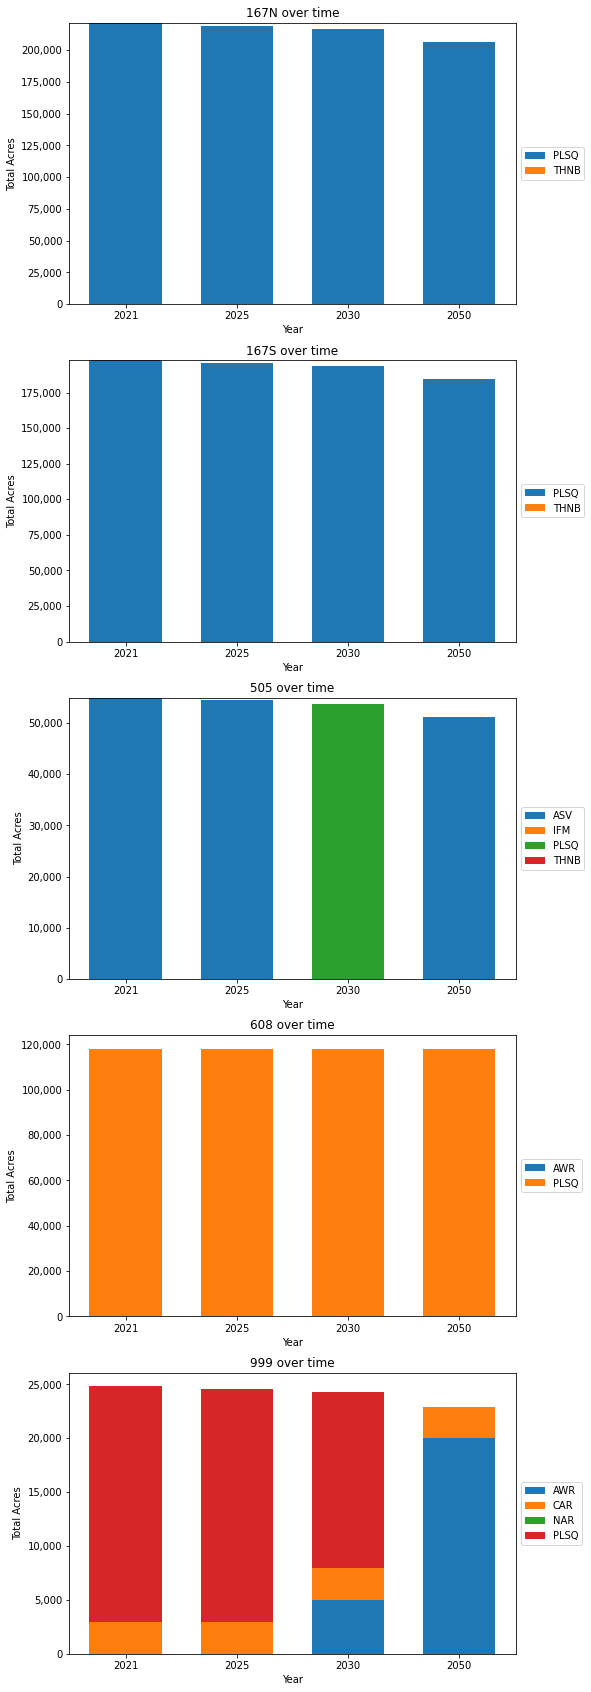

In [398]:
WIDTH = 0.65
fig, ax = plt.subplots(ncols=1, nrows=len(fortype_list), figsize=(8, 30))

for ind, ft in enumerate(fortype_list):
    df_ft = dfvars.loc[ft]
    
    #
    # Step 1: Pull out data
    
    # I gave up trying to find a more pythonic / pandas friendly way to do
    # all this. What I did here is definitely not ideal
    loc_mnglist = df_ft.index.droplevel(['year']).unique().to_list()
    list_dict  ={}
    for mng in loc_mnglist:
        list_dict[mng] = []
    
    for year in year_list:
        dfyr = df_ft.loc[str(year)]
        for mng in loc_mnglist:
            list_dict[mng].append(float(dfyr.loc[mng]['acres']))
    
    #
    # Step 2: Draw Graph
    ft_ax = ax[ind]
    
    bottoms = [0] * len(list_dict[loc_mnglist[0]])
    for mng in loc_mnglist:
        series = list_dict[mng]
        ft_ax.bar(year_list_str, series, WIDTH, label=mng, bottom=bottoms)
        bottoms = [bottoms[i] + x for i, x in enumerate(series)]
    
    ft_ax.set_title(f'{ft} over time')
    ft_ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    ft_ax.set_ylabel('Total Acres')
    ft_ax.set_xlabel('Year')
    
    # This adds commas to big numbers, '10000' => '10,000'
    # See: https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib
    ft_ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

### Figure 2 - Acres of Forest Types Over Time

{'acres': {('167N', '2021', 'PLSQ'): 221277.0,
  ('167N', '2021', 'THNB'): 0.0,
  ('167N', '2025', 'PLSQ'): 219245.0,
  ('167N', '2025', 'THNB'): 0.0,
  ('167N', '2030', 'PLSQ'): 216705.0,
  ('167N', '2030', 'THNB'): 0.0,
  ('167N', '2050', 'PLSQ'): 206545.0,
  ('167N', '2050', 'THNB'): 0.0,
  ('167S', '2021', 'PLSQ'): 197602.0,
  ('167S', '2021', 'THNB'): 0.0,
  ('167S', '2025', 'PLSQ'): 195786.0,
  ('167S', '2025', 'THNB'): 0.0,
  ('167S', '2030', 'PLSQ'): 193516.0,
  ('167S', '2030', 'THNB'): 0.0,
  ('167S', '2050', 'PLSQ'): 184436.0,
  ('167S', '2050', 'THNB'): 0.0,
  ('505', '2021', 'ASV'): 54907.0,
  ('505', '2021', 'IFM'): 0.0,
  ('505', '2021', 'PLSQ'): 0.0,
  ('505', '2021', 'THNB'): 0.0,
  ('505', '2025', 'ASV'): 54403.0,
  ('505', '2025', 'IFM'): 0.0,
  ('505', '2025', 'PLSQ'): 0.0,
  ('505', '2025', 'THNB'): 0.0,
  ('505', '2030', 'ASV'): 0.0,
  ('505', '2030', 'IFM'): 0.0,
  ('505', '2030', 'PLSQ'): 53773.0,
  ('505', '2030', 'THNB'): 0.0,
  ('505', '2050', 'ASV'): 51253.0

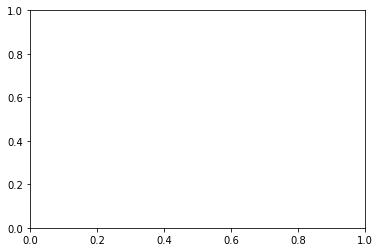

In [431]:
fig, ax = plt.subplots()

# Yea... I give up trying to use Pandas for now
varsdict = dfvars.to_dict()

